# Introduction

In [1]:
# Configurer le GPU pour éviter des Memory Leaks
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Librairies personnalisées
from my_functions.common_functions import *
from my_functions.uni_bi_variate_functions import *
from my_functions.machine_learning_common_functions import *
from my_functions.dimensionality_reduction_functions import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from sklearn import cluster, metrics
from sklearn.manifold import TSNE
from lightgbm  import LGBMClassifier
from sklearn.decomposition import LatentDirichletAllocation, NMF
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from huggingface_hub.inference_api import InferenceApi
from transformers import *
import tensorflow_hub as hub
from multiprocessing import cpu_count
import nltk
import gensim
from openai.embeddings_utils import get_embedding
import openai
import pickle
import os
import time

os.environ["TF_KERAS"]='1'

import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

%matplotlib inline
low_memory=False # faible mémoire vive (RAM) pour gérer la lecture de gros fichiers

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

import  tensorflow as tf
tf.debugging.set_log_device_placement(True)
tf.config.list_physical_devices('GPU') 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8853734287209085967
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6012862464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5738761683338809572
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:00:03.0, compute capability: 6.1"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Chargement & Nettoyage des Données

In [4]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv', low_memory=low_memory)

Le data set contient :
	- 1050 lignes et 15 colonnes.
	- 341 valeurs manquantes, ce qui représente 2.17 % du data set.
Voici un sous-échantillon aléatoire :


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
624,e10cbc680042d27fb747db2ac8e7a585,2016-06-16 23:45:04 +0000,http://www.flipkart.com/oxolloxo-solid-single-...,Oxolloxo Solid Single Breasted Casual Women's ...,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",BZREJH9PC4Z7RGUS,1699.0,1699.0,e10cbc680042d27fb747db2ac8e7a585.jpg,False,Specifications of Oxolloxo Solid Single Breast...,No rating available,No rating available,Oxolloxo,"{""product_specification""=>[{""key""=>""Pattern"", ..."
908,a445d1f73be8f81dd902fd5dc8529416,2016-04-02 19:26:28 +0000,http://www.flipkart.com/cotton-kids-baby-boy-s...,Cotton On Kids Baby Boy's Printed Casual Shirt,"[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",SHTEFW56PAGGFJGA,1099.0,299.0,a445d1f73be8f81dd902fd5dc8529416.jpg,False,Specifications of Cotton On Kids Baby Boy's Pr...,No rating available,No rating available,Cotton On Kids,"{""product_specification""=>[{""key""=>""Pattern"", ..."


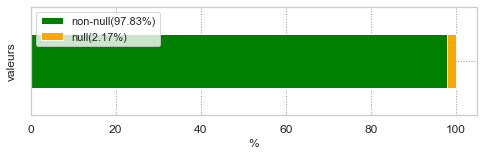

In [5]:
verifier_taille(df)
afficher_echantillon(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
doublons(df['product_name'])

Series([], Name: product_name, dtype: object)

In [8]:
afficher_echantillon(df['description'], n=3).tolist()

Voici un sous-échantillon aléatoire :


['Buy Oxyglow Fruit Massage Cream With Vitamin-E & Lip Balm for Rs.362 online. Oxyglow Fruit Massage Cream With Vitamin-E & Lip Balm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.',
 'Key Features of Aroma Comfort Polyester Brown Printed Eyelet Window Curtain Height: 182 cm Width: 121 cm,Specifications of Aroma Comfort Polyester Brown Printed Eyelet Window Curtain (182 cm in Height, Pack of 2) General Brand Aroma Comfort Designed For Window Type Eyelet Model Name Leaves Design Model ID AC-639 Color Brown Dimensions Length 182 cm In the Box Number of Contents in Sales Package Pack of 2 Body & Design Material Polyester']

In [9]:
df[['product_category_tree', 'product_name']].sort_values(by='product_category_tree').values

array([['["Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations >> Doraemon Gift Family Ceramic Coffee Mug Multicol..."]',
        'Doraemon Gift Family Ceramic Coffee Mug Multicolour Mug - 325 ml'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames >> Cocovey Photo Frames"]',
        'Cocovey Metal Photo Frame'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames >> Indha Craft Photo Frames"]',
        'Indha Craft Cloth Photo Frame'],
       ...,
       ['["Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 149 Analog Watch  - For Girls, Women"]',
        'palito PLO 149 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 166 Analog Watch  - For Girls, Women"]',
        'palito PLO 166 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 169 Analog Watch  - For Girls, Women"]',
        'palito PLO

In [10]:
df['product_category_tree'] = df['product_category_tree'].apply(lambda x : ('>>'.join(x.split('>>')[:-1])).strip())

In [11]:
df[['product_category_tree', 'product_name']].sort_values(by='product_category_tree').values

array([['["Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations',
        'Doraemon Gift Family Ceramic Coffee Mug Multicolour Mug - 325 ml'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames',
        'MH MDF Photo Frame'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames',
        'Indha Craft Cloth Photo Frame'],
       ...,
       ['["Watches >> Wrist Watches >> palito Wrist Watches',
        'palito PLO 149 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches',
        'palito PLO 166 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches',
        'palito PLO 169 Analog Watch  - For Girls, Women']], dtype=object)

## Nettoyage du texte

In [12]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
# Tokenizer
from nltk.tokenize import word_tokenize
import string
import re
# Stop words
from nltk.corpus import stopwords
from stop_words import get_stop_words #pip install stop-words
stop_w = list(set(stopwords.words('english')+get_stop_words('english')))

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2
    
def tokenizer_fct(sentence) :
    # Retirer les ponctuations
    punctuations = [p for p in string.punctuation]
    sentence_clean=sentence
    for p in punctuations:
        sentence_clean = sentence_clean.replace(p, ' ')
    # Retirer les nomres
    sentence_clean = re.sub('\d+', '', sentence_clean)
    # Tokinser la phrase nettoyée
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)    
    lw = lower_start_fct(word_tokens)
    lem_w = lemma_fct(lw)    
    sw = stop_word_filter_fct(lem_w)
    transf_desc_text = ' '.join(sw)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

## Compilation des descriptions en Corpus

In [14]:
corpus = ''.join(df['description'].tolist())
corpus = transform_bow_lem_fct(corpus).split()
len(corpus)

53241

In [15]:
print(corpus[:100])

['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'softly', 'filter', 'li

# Analyse des Fréquences

## MostCommons

In [16]:
fq = nltk.FreqDist(corpus)
fq

FreqDist({'product': 863, 'free': 618, 'delivery': 567, 'genuine': 564, 'shipping': 564, 'cash': 564, 'price': 561, 'replacement': 559, 'day': 553, 'buy': 546, ...})

In [17]:
print(fq.most_common(100))

[('product', 863), ('free', 618), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 561), ('replacement', 559), ('day', 553), ('buy', 546), ('flipkart', 476), ('guarantee', 471), ('com', 468), ('mug', 448), ('feature', 404), ('online', 396), ('color', 363), ('watch', 354), ('type', 325), ('baby', 321), ('pack', 319), ('specification', 313), ('material', 313), ('set', 308), ('cotton', 299), ('box', 296), ('general', 288), ('design', 273), ('package', 269), ('sale', 262), ('analog', 262), ('number', 254), ('warranty', 249), ('quality', 245), ('detail', 243), ('girl', 241), ('inch', 239), ('brand', 238), ('laptop', 236), ('best', 230), ('model', 226), ('ceramic', 219), ('fabric', 211), ('showpiece', 206), ('size', 196), ('made', 189), ('great', 189), ('boy', 184), ('perfect', 184), ('gift', 183), ('india', 180), ('dimension', 177), ('men', 177), ('skin', 175), ('usb', 174), ('home', 170), ('ideal', 167), ('coffee', 164), ('multicolor', 160), ('content', 159)

In [18]:
most_common_words = fq.most_common(38)
print(most_common_words)

[('product', 863), ('free', 618), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 561), ('replacement', 559), ('day', 553), ('buy', 546), ('flipkart', 476), ('guarantee', 471), ('com', 468), ('mug', 448), ('feature', 404), ('online', 396), ('color', 363), ('watch', 354), ('type', 325), ('baby', 321), ('pack', 319), ('specification', 313), ('material', 313), ('set', 308), ('cotton', 299), ('box', 296), ('general', 288), ('design', 273), ('package', 269), ('sale', 262), ('analog', 262), ('number', 254), ('warranty', 249), ('quality', 245), ('detail', 243), ('girl', 241), ('inch', 239), ('brand', 238)]


In [19]:
exclud_common = ['mug', 'watch', 'baby', 'cotton', 'girl']
most_common_words = [w for w,c in most_common_words if w not in exclud_common]
print(most_common_words)

['product', 'free', 'delivery', 'genuine', 'shipping', 'cash', 'price', 'replacement', 'day', 'buy', 'flipkart', 'guarantee', 'com', 'feature', 'online', 'color', 'type', 'pack', 'specification', 'material', 'set', 'box', 'general', 'design', 'package', 'sale', 'analog', 'number', 'warranty', 'quality', 'detail', 'inch', 'brand']


In [20]:
len(set(corpus))

4711

In [21]:
print(fq.most_common()[-200:])

[('souvenir', 1), ('grinding', 1), ('pendulum', 1), ('applicable', 1), ('scene', 1), ('gfssp', 1), ('placket', 1), ('barrel', 1), ('cuff', 1), ('sits', 1), ('flushed', 1), ('pop', 1), ('cheek', 1), ('buildable', 1), ('applicator', 1), ('brushkey', 1), ('jali', 1), ('tblue', 1), ('tbtts', 1), ('aarika', 1), ('banded', 1), ('brocade', 1), ('patiala', 1), ('dupattaspecifications', 1), ('rishan', 1), ('rishak', 1), ('fsp', 1), ('restitchkey', 1), ('bundle', 1), ('joy', 1), ('heritage', 1), ('heritagebuy', 1), ('alteration', 1), ('chino', 1), ('kgt', 1), ('waterseven', 1), ('twisting', 1), ('travellingpedrini', 1), ('knifebuy', 1), ('choclate', 1), ('revealed', 1), ('added', 1), ('revealing', 1), ('persnalized', 1), ('mail', 1), ('resultion', 1), ('ksrao', 1), ('gmail', 1), ('ounce', 1), ('tre', 1), ('weightlessly', 1), ('frizzy', 1), ('unruly', 1), ('formulated', 1), ('sunflower', 1), ('frizz', 1), ('contrl', 1), ('improves', 1), ('manageal', 1), ('inaugration', 1), ('mukut', 1), ('sai', 1

## Bag-of-Words

In [22]:
df_corpus = pd.DataFrame(df['product_name'].values, columns=['name'])
df_corpus['description'] = df['description'].apply(lambda s: ' '.join([w for w in transform_bow_lem_fct(s).split() if w not in most_common_words]))
df_corpus['categ_str'] = df['product_category_tree'].apply(lambda s: s.split('>>')[0].split('"')[-1].strip())
df_corpus['categ'] = LabelEncoder().fit_transform(df_corpus['categ_str'])
categs = df_corpus['categ'].values.tolist()
categs_str = df_corpus['categ_str'].unique().tolist()
df_corpus

,name,description,categ_str,categ
0,Elegance Polyester Multicolor Abstract Eyelet ...,key elegance polyester multicolor abstract eye...,Home Furnishing,4
1,Sathiyas Cotton Bath Towel,sathiyas cotton bath towel bath towel red yell...,Baby Care,0
2,Eurospa Cotton Terry Face Towel Set,key eurospa cotton terry face towel size small...,Baby Care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,key santosh royal fashion cotton printed king ...,Home Furnishing,4
4,Jaipur Print Cotton Floral King sized Double B...,key jaipur print cotton floral king sized doub...,Home Furnishing,4
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,oren empower extra large self adhesive sticker...,Baby Care,0
1046,Wallmantra Large Vinyl Sticker Sticker,wallmantra large vinyl sticker sticker bring h...,Baby Care,0
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,uberlyfe extra large pigmented polyvinyl film ...,Baby Care,0
1048,Wallmantra Medium Vinyl Sticker Sticker,wallmantra medium vinyl sticker sticker wallma...,Baby Care,0


In [23]:
print('Nombre de catégories:', len(df_corpus['categ'].unique()))

Nombre de catégories: 7


### Count

In [24]:
# création du bag of words (CountVectorizer)
feat = 'description'
ngram = (1,1)

time1 = time.time()
cvect = CountVectorizer(max_df=0.95, ngram_range=ngram)
count_bow = cvect.fit_transform(df_corpus[feat])
time_count = np.round(time.time() - time1,0)

In [25]:
print(tuple(zip(sorted(set(df_corpus.iloc[0,1].split())), [count_bow.toarray()[0,cvect.vocabulary_[w]] for w in sorted(set(df_corpus.iloc[0,1].split()))])))

(('abstract', 4), ('amount', 1), ('ant', 1), ('anti', 1), ('apart', 1), ('apparance', 1), ('appeal', 1), ('attention', 1), ('beauty', 1), ('body', 1), ('bright', 2), ('bring', 1), ('close', 1), ('contemporary', 1), ('content', 1), ('create', 1), ('curtain', 11), ('designed', 1), ('dimension', 1), ('door', 5), ('draw', 2), ('duster', 1), ('elegance', 4), ('elegant', 2), ('enhances', 1), ('environment', 1), ('evening', 1), ('eyelet', 6), ('fabric', 1), ('filter', 1), ('first', 1), ('floral', 1), ('get', 1), ('give', 1), ('given', 1), ('good', 1), ('heart', 1), ('height', 2), ('high', 1), ('home', 2), ('interior', 1), ('joyous', 1), ('key', 1), ('length', 1), ('light', 1), ('look', 1), ('loving', 1), ('made', 1), ('make', 1), ('metal', 1), ('model', 2), ('modernistic', 1), ('moment', 1), ('morning', 2), ('multicolor', 4), ('name', 1), ('polyester', 6), ('print', 1), ('ray', 1), ('right', 1), ('ring', 1), ('romantic', 1), ('room', 2), ('shrinkage', 1), ('slide', 1), ('smoothly', 1), ('soft

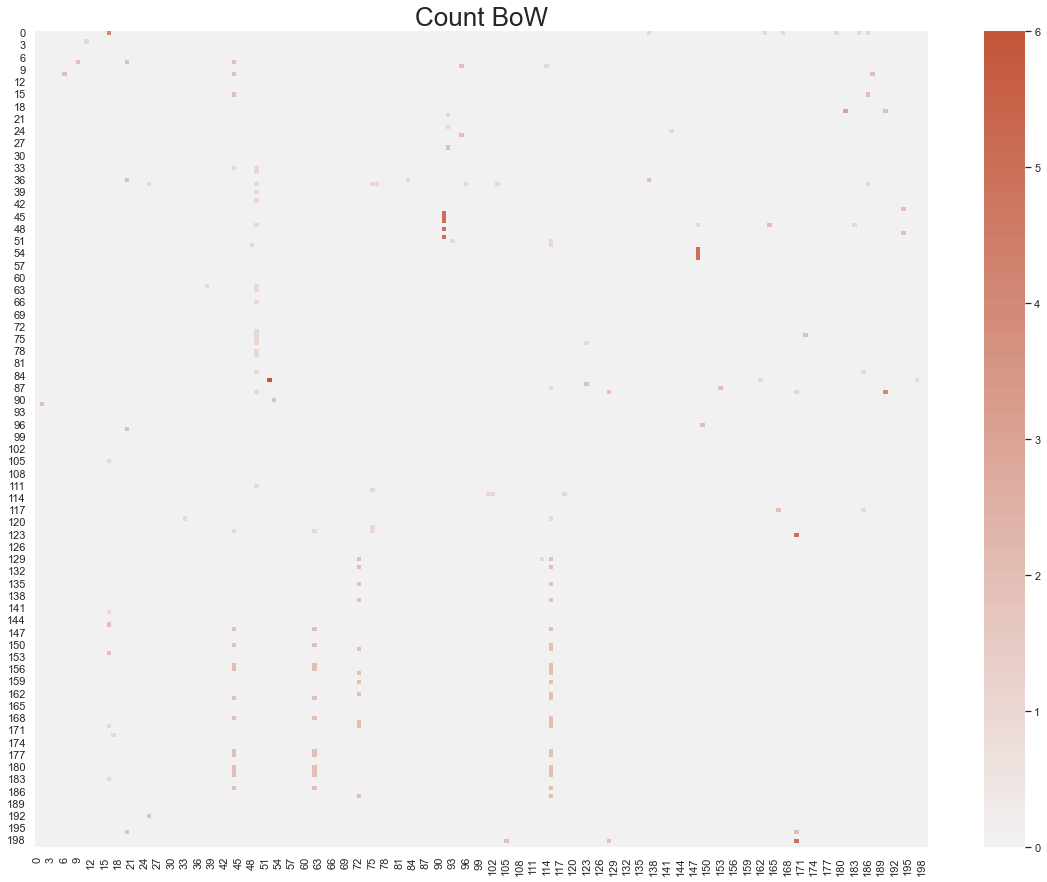

In [26]:
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(count_bow.toarray()[:200,:200], center=0, cmap = sns.diverging_palette(230, 20, as_cmap=True))
plt.title('Count BoW', fontsize=26)
plt.show()

### TF-IDF

In [27]:
# création du bag of words (Tf-idf)
feat = 'description'
ngram = (1,1)

time1 = time.time()
ctf = TfidfVectorizer(max_df=0.95, ngram_range=ngram)
tfidf_bow = ctf.fit_transform(df_corpus[feat])
time_tfidf = np.round(time.time() - time1,0)

tfidf_bow_df=pd.DataFrame(tfidf_bow.toarray(), columns=sorted(list(cvect.vocabulary_)))

In [28]:
tfidf_bow.shape

(1050, 4494)

In [29]:
print(tuple(zip(sorted(set(df_corpus.iloc[0,1].split())), [tfidf_bow.toarray()[0,ctf.vocabulary_[w]] for w in sorted(set(df_corpus.iloc[0,1].split()))])))

(('abstract', 0.17289492414012203), ('amount', 0.06842765843641509), ('ant', 0.06842765843641509), ('anti', 0.05888608299946089), ('apart', 0.0714233672225812), ('apparance', 0.07564558161533595), ('appeal', 0.061209735257494215), ('attention', 0.06610400617838176), ('beauty', 0.05698752086473946), ('body', 0.03862281083608371), ('bright', 0.11777216599892178), ('bring', 0.05116009505920403), ('close', 0.07564558161533595), ('contemporary', 0.05615401518048682), ('content', 0.030896822895826855), ('create', 0.06420544404366034), ('curtain', 0.5574323694421027), ('designed', 0.041134094512327864), ('dimension', 0.030686446811910194), ('door', 0.26101145166298334), ('draw', 0.13685531687283017), ('duster', 0.07564558161533595), ('elegance', 0.2504009305235186), ('elegant', 0.09489189085557052), ('enhances', 0.06260023263087965), ('environment', 0.06610400617838176), ('evening', 0.06842765843641509), ('eyelet', 0.3100089589232401), ('fabric', 0.03327374003713559), ('filter', 0.07564558161

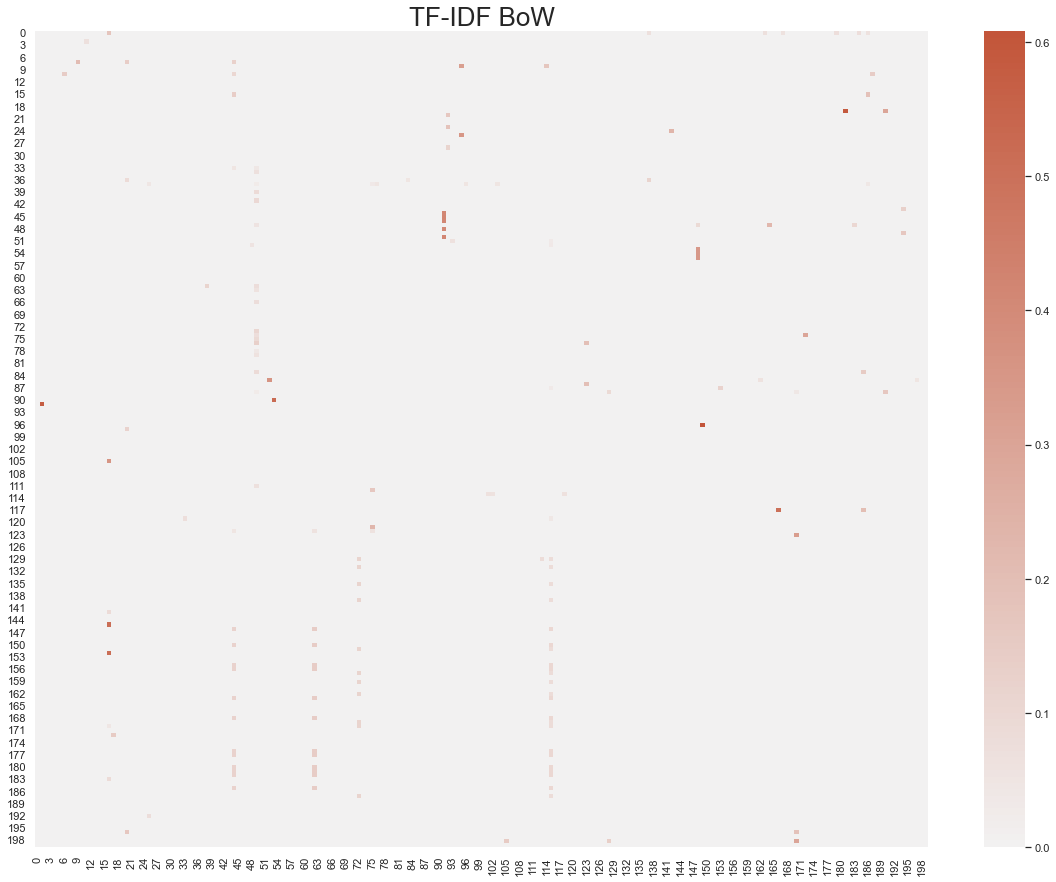

In [30]:
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(tfidf_bow.toarray()[:200,:200], center=0, cmap = sns.diverging_palette(230, 20, as_cmap=True))
plt.title('TF-IDF BoW', fontsize=26)
plt.show()

# Topics Analysis

In [31]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx), " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

## LDA

In [32]:
n_topics = len(set(categs))
print('n_topics:', n_topics)

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=30.,
        random_state=0)

# Fitter sur les données
lda.fit(tfidf_bow)

no_top_words = n_topics
display_topics(lda, ctf.get_feature_names(), no_top_words)

n_topics: 7
Topic 0: sticker mug laptop skin baby cotton multicolor
Topic 1: kadhai cell pizza glass rega cutter battery
Topic 2: combo playboy archies deodorant paris lal haveli
Topic 3: watch men india discount woman great sonata
Topic 4: led tenda bulb light usb best lamp
Topic 5: edimax lowest pizza wna cutter wheel offering
Topic 6: router wireless combo link dsl asus mxofere


c:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## NMF

In [33]:
# Run NMF
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf_bow)

no_top_words = n_topics
display_topics(nmf, ctf.get_feature_names(), no_top_words)

Topic 0: watch men discount india great sonata woman
Topic 1: mug coffee ceramic perfect prithish tea printland
Topic 2: baby girl fabric dress cotton boy sleeve
Topic 3: rockmantra mug ceramic thrilling crafting porcelain permanent
Topic 4: abstract blanket double single quilt comforter raymond
Topic 5: laptop battery cell pavilion lapguard skin mouse
Topic 6: towel cotton bath soft hand face terry


c:\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Clustering

In [34]:
Scores = pd.DataFrame(columns=['Model', 'ARI', 'hue'], index=[])

In [35]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, y) :    
    num_labels=len(set(y))
    tsne = TSNE(n_components=2, perplexity=10, n_iter=2000, learning_rate=200, init='random', random_state=0)
    X_tsne = tsne.fit_transform(features)

    n=min(len(y), len(X_tsne))
    X_tsne = X_tsne[:n, :]
    y = y[:n]
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, init='k-means++', n_init=50, random_state=0)
    cls.fit(X_tsne)        
    ARI = np.round(metrics.adjusted_rand_score(y, cls.labels_),4)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y, labels, ARI, time=None, model_name=None, Scores=None) :
    n=min(len(y), len(labels))
    X_tsne = X_tsne[:n, :]
    y = y[:n]
    labels = labels[:n]

    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y, cmap='Set1', s=10)
    ax.legend(handles=scatter.legend_elements()[0], labels=list(set(y)), loc="best", title="Categorie")
    plt.title('Catégories Réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1', s=10)
    ax.legend(handles=scatter.legend_elements()[0], labels=list(set(labels)), loc="best", title="Clusters")
    plt.title('Clusters')
    
    plt.show()

    # Sauvgarder les scores
    stop = False
    try:
        if Scores == None:
            stop = True
    except:
        pass
    if not stop:
        # Evaluatation        
        if model_name not in Scores['Model'].values:
            i = len(Scores)
            Scores.loc[i, 'Model'] = model_name
        Scores.loc[Scores['Model']==model_name, 'ARI'] = ARI
        Scores.loc[Scores['Model']==model_name, 'Time(s)'] = time
        # Convertion de type
        Scores['ARI'] = Scores['ARI'].astype('float')
        print('ARI:', ARI, 'Time:', time)

## Bag-of-Words

### Count

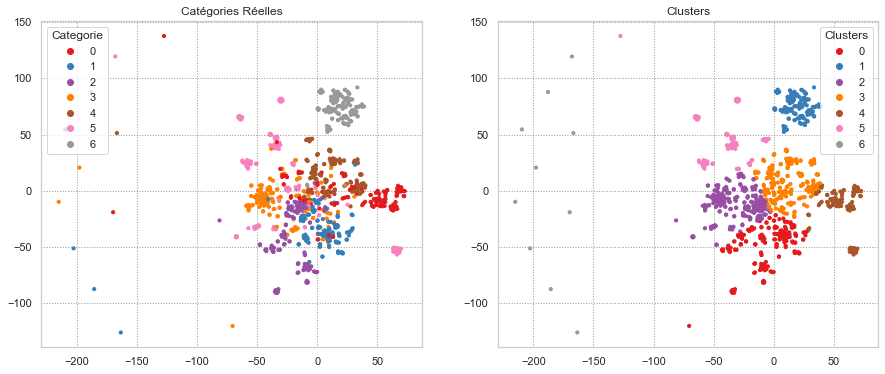

ARI: 0.4058 Time: 0.0


In [36]:
ARI, X_tsne, labels = ARI_fct(count_bow, categs)
TSNE_visu_fct(X_tsne, categs, labels, ARI, time_count, 'Count', Scores)

### TF-IDF

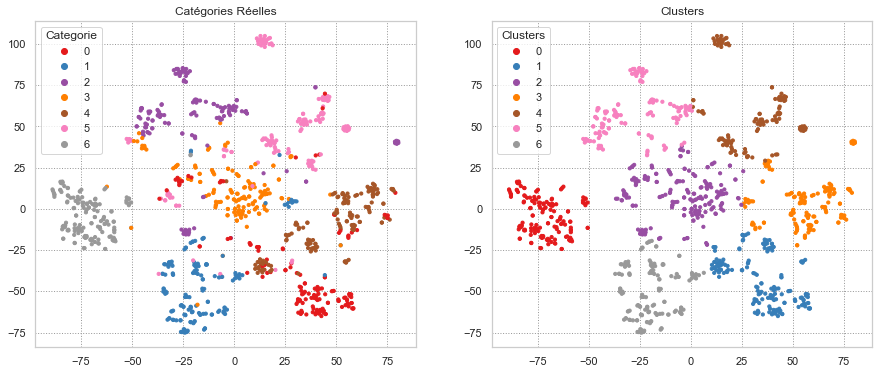

ARI: 0.5904 Time: 0.0


In [37]:
ARI, X_tsne, labels = ARI_fct(tfidf_bow, categs)
TSNE_visu_fct(X_tsne, categs, labels, ARI, time_tfidf, 'TF-IDF', Scores)

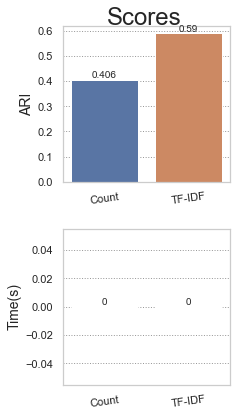

In [38]:
display_scores(Scores)

## Embeddings

In [39]:
embeddings = {}

def load_embeddings():
    global embeddings
    try:        
        with open("embeddings.pkl", "rb") as f:
            embeddings = pickle.load(f)
    except:
        pass

def save_embeddings(model, embeds):
    global embeddings
    load_embeddings()
    embeddings[model] = embeds
    with open("embeddings.pkl", "wb") as f:
        pickle.dump(embeddings, f)

In [40]:
best_params = pd.DataFrame(columns=['Model', 'max_length', 'size', 'ARI'], index=[])

def load_best_params():
    global best_params    
    best_params = pd.read_csv('best_params.csv', dtype={'max_length': 'int32', 'size': 'int32'}, low_memory=low_memory)

def save_best_params(model_name):
    global best_params     
    # Convertion de type
    best_params2 = best_params.copy()
    load_best_params()    
    if model_name not in best_params['Model'].values:
        i = len(best_params)
        best_params.loc[i, 'Model'] = model_type    
    best_params.loc[best_params['Model']==model_name, :] = best_params2[best_params2['Model']==model_name]
    best_params.to_csv('best_params.csv', index=False)

In [41]:
recompute = 0 # 0: display previously computed embeddings, 1: recompute embeddings with previously found best_params, 2: grid search of the best_params
 # Load previously computed embeddings
load_embeddings()
# Load previously computed best_params
load_best_params()

### Gensim

In [42]:
sentences = df_corpus['description'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [43]:
def gensim_embd(sentences, model_type='Word2Vec', vector_size=250, max_length=30, window=5, min_count=1, epochs=100, verbose=True, Scores=None):
    # Création et entraînement du modèle FastText
    if verbose:
        print("Build & train "+model_type+" model ...")
    
    time1 = time.time()
    model = None
    if model_type == 'Word2Vec':
        model = gensim.models.Word2Vec(min_count=min_count, window=window, vector_size=vector_size, seed=0, workers=cpu_count())
    if model_type == 'FastText':
        model = gensim.models.FastText(min_count=min_count, window=window, vector_size=vector_size, seed=0, workers=cpu_count())
    
    model.build_vocab(sentences)
    model.train(sentences, total_examples=model.corpus_count, epochs=epochs)
    model_vectors = model.wv
    words = model_vectors.index_to_key
    if verbose:
        print("Vocabulary size: %i" % len(words))
        print(model_type+" trained")


    # Préparation des sentences (tokenization)
        print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                        maxlen=max_length,
                                                        padding='post') 
                                                    
    num_words = len(tokenizer.word_index) + 1
    if verbose:
        print("Number of unique words: %i" % num_words)

    # Création de la matrice d'embedding
        print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, vector_size))
    i=0
    j=0
        
    for word, idx in word_index.items():
        i +=1
        if word in words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
    word_rate = np.round(j/i,4)
    if verbose:
        print("Word embedding rate : ", word_rate)
        print("Embedding matrix: %s" % str(embedding_matrix.shape))


    # Création du modèle
    word_input=Input(shape=(max_length,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                            output_dim=vector_size,
                            weights = [embedding_matrix],
                            input_length=max_length)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)

    if verbose:
        embed_model.summary()    

    features = embed_model.predict(x_sentences, workers=cpu_count(), use_multiprocessing=True)
    _time = np.round(time.time() - time1,0)

    ARI, X_tsne, labels = ARI_fct(features, categs) 
    return ARI, X_tsne, labels, _time, features

def gensim_embd_grid(Scores, sentences, model_type='Word2Vec', vector_size_min=50, window=5, min_count=1, epochs=100, recompute=3, verbose=False):
    best_ARI = best_params.loc[best_params['Model']==model_type, 'ARI'].tolist()[0] if model_type in best_params['Model'].tolist() and recompute==2 else 0
    best_vector_size = best_params.loc[best_params['Model']==model_type, 'size'].tolist()[0] if model_type in best_params['Model'].tolist() and recompute==2 else 0
    best_max_length = best_params.loc[best_params['Model']==model_type, 'max_length'].tolist()[0] if model_type in best_params['Model'].tolist() and recompute==2 else 0
    best_X_tsne = None
    best_labels = None
    best_time = None

    for vector_size in np.arange(vector_size_min,700+1, 20):
        for max_length in np.arange(20,80+1, 5):
            print('==================== vector_size=', vector_size, ' max_length=', max_length, '====================')
            ARI, X_tsne, labels, _time, features = gensim_embd(sentences, model_type, vector_size, max_length, window, min_count, epochs, verbose)
            print('ARI:', ARI, 'Time:', _time)

            if ARI > best_ARI:
                best_ARI = ARI
                best_vector_size = vector_size
                best_max_length = max_length
                best_X_tsne = X_tsne
                best_labels = labels
                best_time = _time                
                save_embeddings(model_type, features)
                      
                # Save Best Params
                if model_type not in best_params['Model'].values:
                    i = len(best_params)
                    best_params.loc[i, 'Model'] = model_type
                best_params.loc[best_params['Model']==model_type, 'ARI'] = best_ARI
                best_params.loc[best_params['Model']==model_type, 'size'] = best_vector_size
                best_params.loc[best_params['Model']==model_type, 'max_length'] = best_max_length
                best_params.loc[best_params['Model']==model_type, 'time'] = best_time
                save_best_params(model_type)

    # Display Best Params
    print('best_ARI=', best_ARI, 'best_vector_size=', best_vector_size, 'best_max_length=', best_max_length)
    best_ARI, best_X_tsne, best_labels = ARI_fct(embeddings[model_name], categs)
    TSNE_visu_fct(best_X_tsne, categs, best_labels, best_ARI, best_time, model_type+'('+str(vector_size)+','+str(max_length)+')', Scores)   

def gensim_run(model_type, recompute=0, verbose=False, vector_size_min=50):
    c1= model_type in embeddings
    c2 = model_type in best_params['Model'].values

    vector_size = None
    max_length = None
    if c2:
        vector_size = best_params.loc[best_params['Model']==model_type, 'size'].tolist()[0]
        max_length = best_params.loc[best_params['Model']==model_type, 'max_length'].tolist()[0]                    
    
    if c1 and recompute==0:
        _time = best_params.loc[best_params['Model']==model_type, 'time'].tolist()[0]
        ARI, X_tsne, labels = ARI_fct(embeddings[model_type], categs)
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_type+'('+str(vector_size)+','+str(max_length)+')', Scores)
    
    if recompute==1 or (not c1 and c2):
        best_ARI = round(best_params.loc[best_params['Model']==model_type, 'ARI'].tolist()[0], 3)
        ARI = 0
        X_tsne = labels = _time = features = None        

        while ARI < best_ARI:            
            ARI, X_tsne, labels, _time, features = gensim_embd(Scores=Scores, sentences=sentences, model_type=model_type, vector_size=vector_size, max_length=max_length, verbose=verbose)
            print('current_ARI:', ARI, 'best_ARI:', best_ARI, 'time:', _time)
        
        clear_output(wait=True)
        save_embeddings(model_type, features)
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_type+'('+str(vector_size)+','+str(max_length)+')', Scores)
        
        best_params.loc[best_params['Model']==model_type, 'ARI'] = ARI
        best_params.loc[best_params['Model']==model_type, 'time'] = _time
        save_best_params(model_type)
    
    if recompute>=2 or (not c1 and not c2):
        gensim_embd_grid(Scores=Scores, sentences=sentences, model_type=model_type, vector_size_min=vector_size_min,recompute=recompute, verbose=verbose)

#### Word2Vec

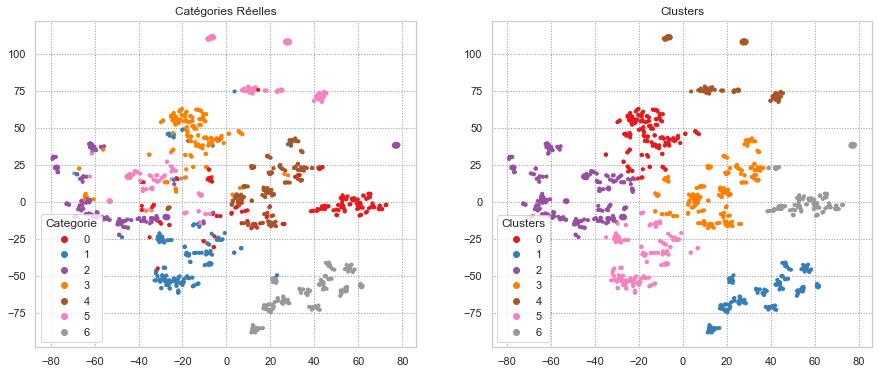

ARI: 0.6191 Time: 7


In [44]:
gensim_run('Word2Vec', recompute=recompute)

#### FastText

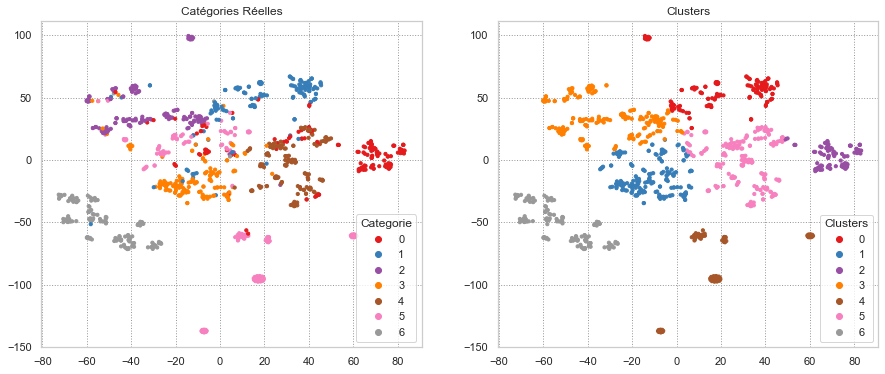

ARI: 0.5986 Time: 254


In [45]:
# gensim_run('FastText', recompute=recompute, vector_size_min=670, verbose=False)
gensim_run('FastText', recompute=recompute)

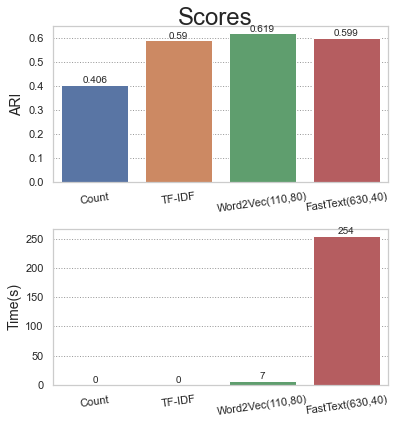

In [46]:
display_scores(Scores)

### BERT

In [47]:
my_tokenizers = {}

def load_my_tokenizers():    
    global my_tokenizers
    try:
        with open("my_tokenizers.pkl", "rb") as f:
            my_tokenizers = pickle.load(f)
    except:
        pass

def save_my_tokenizers(model_name, tokenizer):
    global my_tokenizers
    load_my_tokenizers()
    my_tokenizers[model_name] = tokenizer
    with open("my_tokenizers.pkl", "wb") as f:
        pickle.dump(my_tokenizers, f)

my_models = {}

def load_my_models():    
    global my_models
    path = "C:/my_models/Text/"
    
    for mode in ['HF', 'TFhub']:
        my_models[mode]={}
        for (dirpath, dirnames, filenames) in os.walk(path+mode+'/'):
            if dirpath == path+mode+'/':
                for model_name in dirnames:
                    if mode == 'HF':
                        my_models[mode][model_name] = load_model(path+mode+'/'+model_name)
                    if mode == 'TFhub':
                        my_models[mode][model_name] = hub.KerasLayer(path+mode+'/'+model_name, trainable=True)

def save_my_models(model_name, model, mode):
    global my_models
    load_my_models()
    my_models[mode][model_name] = model
    
    path = "C:/my_models/Text/"
    if mode == 'HF':
        model.save(path+mode+"/"+model_name)

In [48]:
# Load previously downloaded models
load_my_models()
# Load previously downloaded tokenizers
load_my_tokenizers()

In [49]:
# Fonction de préparation des sentences
def inp_fct(model_type, sentences, tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    inp_tot = []

    for sent in sentences:
        inp = tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length' if 'gpt' not in model_type else False,
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(inp['input_ids'][0])
        token_type_ids.append(inp['token_type_ids'][0])
        attention_mask.append(inp['attention_mask'][0])
        inp_tot.append((inp['input_ids'][0], 
                             inp['token_type_ids'][0], 
                             inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, inp_tot
    

# Fonction de création des features
def feature_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    model_name = model_type + '_' + mode
    batch_size = b_size
    batch_size_pred = b_size
    tokenizer = None
    if model_name not in my_tokenizers:
        save_my_tokenizers(model_name, AutoTokenizer.from_pretrained(model_type))
    tokenizer = my_tokenizers[model_name]

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, inp_tot = inp_fct(model_type, sentences[idx:idx+batch_size], 
                                                                      tokenizer, max_length)
        
        if mode=='HF' :    #  HuggingFace
            if 'distilbert' in model_type:
                outputs = model.predict([input_ids, attention_mask], batch_size=batch_size_pred)
            else:
                outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Tensorflow Hub
            text_preprocessed = {"input_ids" : input_ids, 
                                 "attention_mask" : attention_mask, 
                                 }
            if 'distilbert' not in model_type:
                text_preprocessed["token_type_ids"] = token_type_ids
            outputs = model(text_preprocessed)
            display(outputs)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features = np.array(last_hidden_states_tot).mean(axis=1)
     
    return features, last_hidden_states_tot

def compare(sentences, model_type, mode, max_length=64, batch_size=10, display=True, model_url=None, Scores=None):
    model_name =  model_type + '_'+mode
    time1 = time.time()
    model = None
    
    if model_name not in my_models[mode]:
        if mode=='HF': #Hugging Face
            save_my_models(model_name, TFAutoModel.from_pretrained(model_type), mode)        
        if mode=='TFhub' : # Tensorflow Hub            
            save_my_models(model_name, hub.KerasLayer(model_url, trainable=True), mode)
    model = my_models[mode][model_name]   
    features, last_hidden_states_tot = feature_fct(model, model_type, sentences, max_length, batch_size, mode=mode)

    _time = np.round(time.time() - time1,0)

    ARI, X_tsne, labels = ARI_fct(features, categs)
    if display:
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_name+'('+str(batch_size)+','+str(max_length)+')', Scores)        
        return features
    else:
        return ARI, X_tsne, labels, _time, features

def compare_grid(Scores, sentences, model_type, mode, model_url=None, recompute=3, max_length_min=20):
    model_name =  model_type + '_'+mode
    best_ARI = best_params.loc[best_params['Model']==model_name, 'ARI'].tolist()[0] if model_name in best_params['Model'].tolist() and recompute==2 else 0
    best_max_length = best_params.loc[best_params['Model']==model_name, 'max_length'].tolist()[0] if model_name in best_params['Model'].tolist() and recompute==2 else 0
    best_batch_size = best_params.loc[best_params['Model']==model_name, 'size'].tolist()[0] if model_name in best_params['Model'].tolist() and recompute==2 else 0    
    best_X_tsne = None
    best_labels = None
    best_time = None

    for max_length in range(max_length_min, 70+1, 5):
        for batch_size in range(5,30+1, 5):
            print('========================== max_length =', max_length, 'batch_size =', batch_size, '==========================')
            ARI, X_tsne, labels, _time, features = compare(sentences, model_type, mode, max_length, batch_size, display=False, model_url=model_url)          
            print('ARI:', ARI, 'best_ARI:', best_ARI, 'Time:', _time)  

            if ARI > best_ARI:
                best_ARI = ARI
                best_max_length = max_length
                best_batch_size = batch_size
                best_X_tsne  = X_tsne
                best_labels = labels
                best_time = _time
                save_embeddings(model_name, features)

                # Save Best Params
                if model_name not in best_params['Model'].values:
                    i = len(best_params)
                    best_params.loc[i, 'Model'] = model_name
                best_params.loc[best_params['Model']==model_name, 'ARI'] = best_ARI
                best_params.loc[best_params['Model']==model_name, 'size'] = best_batch_size
                best_params.loc[best_params['Model']==model_name, 'max_length'] = best_max_length
                best_params.loc[best_params['Model']==model_name, 'time'] = best_time
                save_best_params(model_name)
    # Display Best Params    
    print('best_ARI=', best_ARI, 'best_batch_size=', best_batch_size, 'best_max_length=', best_max_length)
    best_ARI, best_X_tsne, best_labels = ARI_fct(embeddings[model_name], categs)
    TSNE_visu_fct(best_X_tsne, categs, best_labels, best_ARI, best_time, model_name+'('+str(batch_size)+','+str(max_length)+')', Scores)

def BERT(model_type, mode, model_url=None, recompute=0, max_length_min=20):        
    model_name =  model_type + '_'+mode

    c1 = model_name in embeddings
    c2 = model_name in best_params['Model'].values

    batch_size = None
    max_length = None
    if c2:
        batch_size=best_params.loc[best_params['Model']==model_name, 'size'].tolist()[0]
        max_length=best_params.loc[best_params['Model']==model_name, 'max_length'].tolist()[0]                
    
    if c1 and recompute==0:
        _time = best_params.loc[best_params['Model']==model_name, 'time'].tolist()[0]
        ARI, X_tsne, labels = ARI_fct(embeddings[model_name], categs)
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_name+'('+str(batch_size)+','+str(max_length)+')', Scores)

    if recompute==1 or (not c1 and c2):
        best_ARI = round(best_params.loc[best_params['Model']==model_name, 'ARI'].tolist()[0], 3)
        ARI = 0
        X_tsne = labels = _time = features = None        

        while ARI < best_ARI:            
            ARI, X_tsne, labels, _time, features = compare(Scores=Scores, sentences=sentences, model_type=model_type, mode=mode, model_url=model_url, batch_size=batch_size, max_length=max_length, display=False)
            print('current_ARI:', ARI, 'best_ARI:', best_ARI, 'time:', _time)
        
        clear_output(wait=True)
        save_embeddings(model_name, features)
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_name+'('+str(batch_size)+','+str(max_length)+')', Scores)
        
        best_params.loc[best_params['Model']==model_name, 'ARI'] = ARI
        best_params.loc[best_params['Model']==model_name, 'time'] = _time
        save_best_params(model_name)

    if recompute>=2 or (not c1 and not c2):
        compare_grid(Scores=Scores, sentences=sentences, model_type=model_type, mode=mode, model_url=model_url, recompute=recompute, max_length_min=max_length_min)

#### HuggingFace

In [50]:
recompute = 0 # 0: display previously computed embeddings, 1: recompute embeddings with previously found best_params, 2: grid search of the best_params
sentences = df_corpus['description'].to_list()

##### Bert (basic)

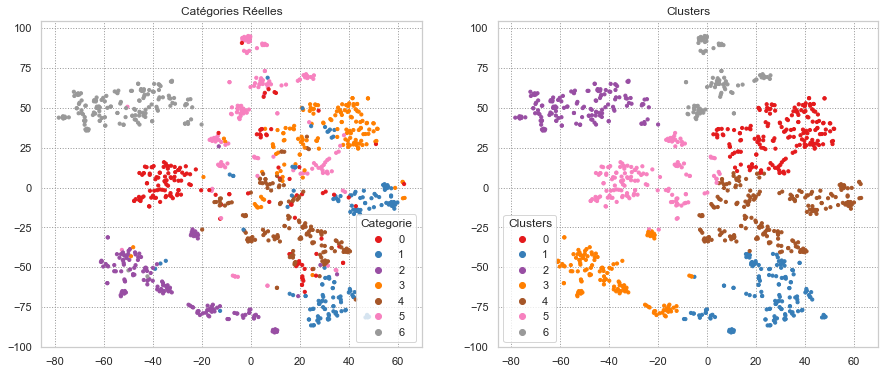

ARI: 0.4941 Time: 10


In [52]:
BERT('bert-base-uncased', 'HF', recompute=recompute)

##### RoBerta

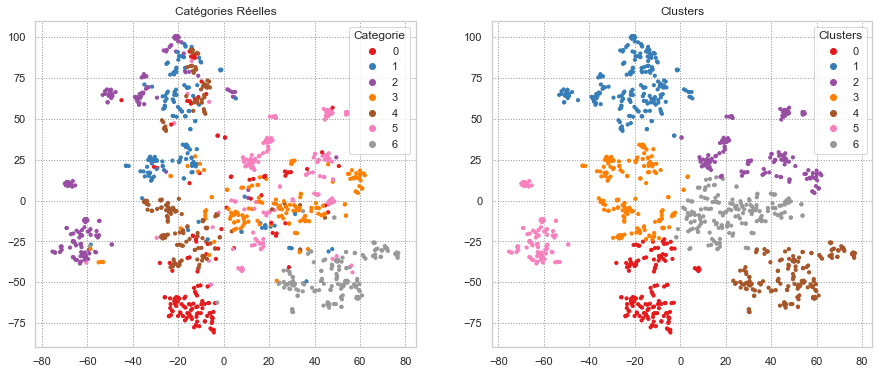

ARI: 0.3863 Time: 9


In [53]:
BERT('roberta-base', 'HF', recompute=recompute)

##### DistilBert

In [54]:
load_my_models()

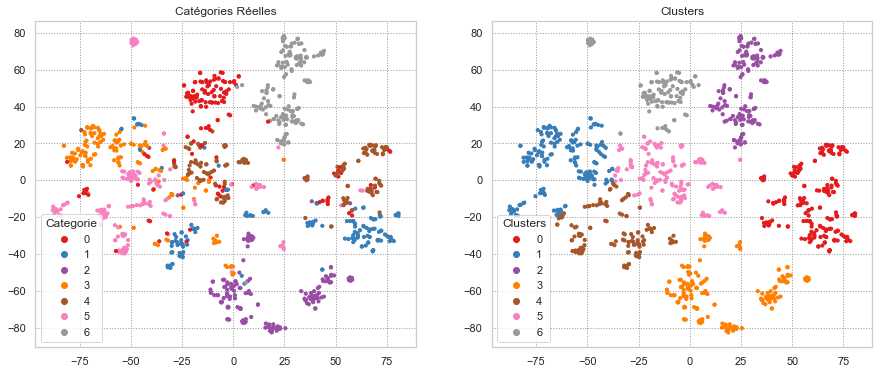

ARI: 0.4765 Time: 26


In [55]:
BERT('distilbert-base-uncased', 'HF', recompute=recompute)

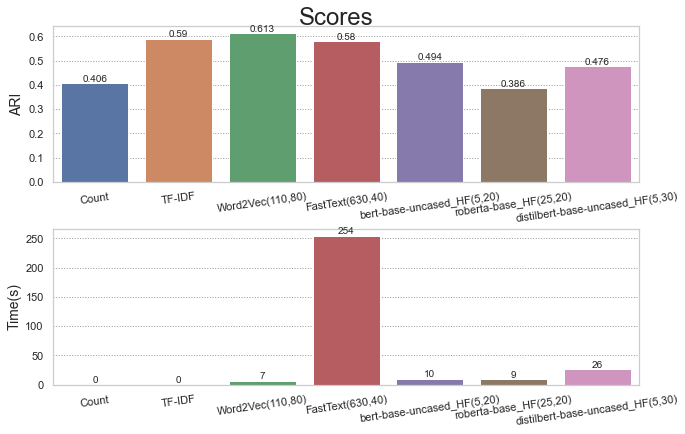

In [56]:
display_scores(Scores)

#### TensorFlow Hub

In [57]:
recompute = 0 # 0: display previously computed embeddings, 1: recompute embeddings with previously found best_params, 2: grid search of the best_params
sentences = df_corpus['description'].to_list()

##### Bert (basic)

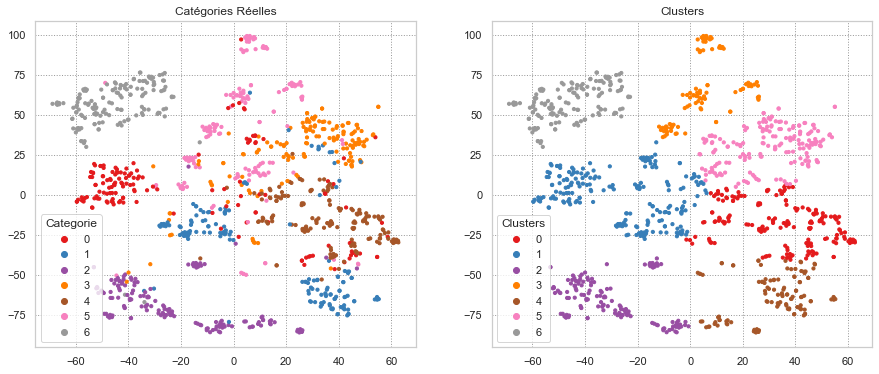

ARI: 0.5284 Time: 17


In [58]:
model_type='bert-base-uncased'
model_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
BERT(model_type, 'TFhub', model_url, recompute=recompute)

##### RoBerta

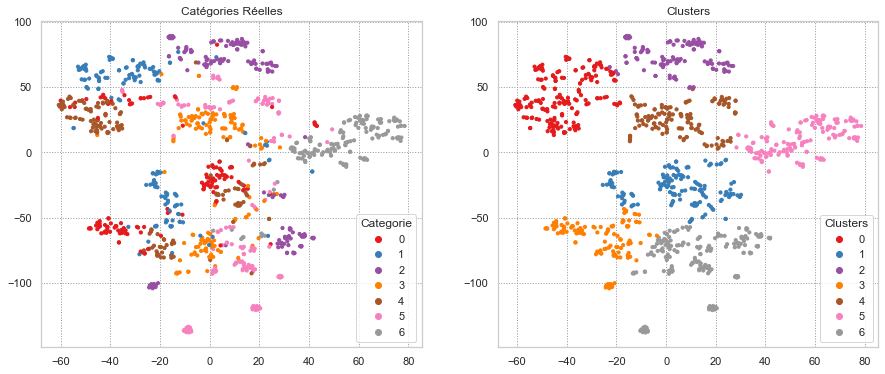

ARI: 0.3347 Time: 10


In [59]:
model_type='roberta-base'
model_url='https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1'
BERT(model_type, 'TFhub', model_url, recompute=recompute)

##### DistilBert

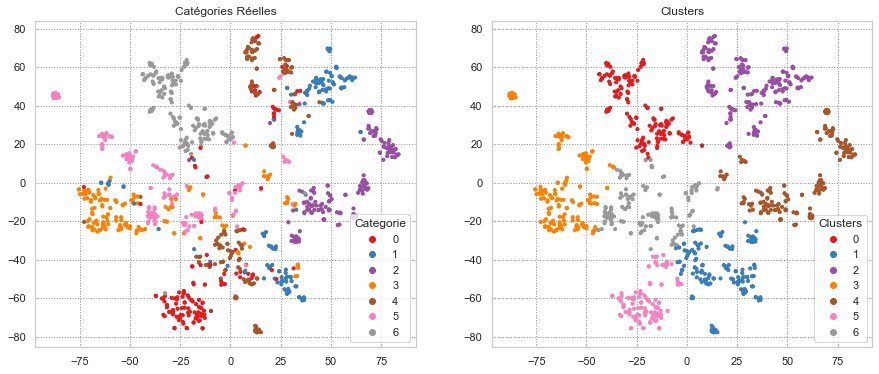

ARI: 0.4787 Time: 7


In [60]:
model_type='distilbert-base-uncased'
model_url='https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1'
BERT(model_type, 'TFhub', model_url, recompute=recompute)

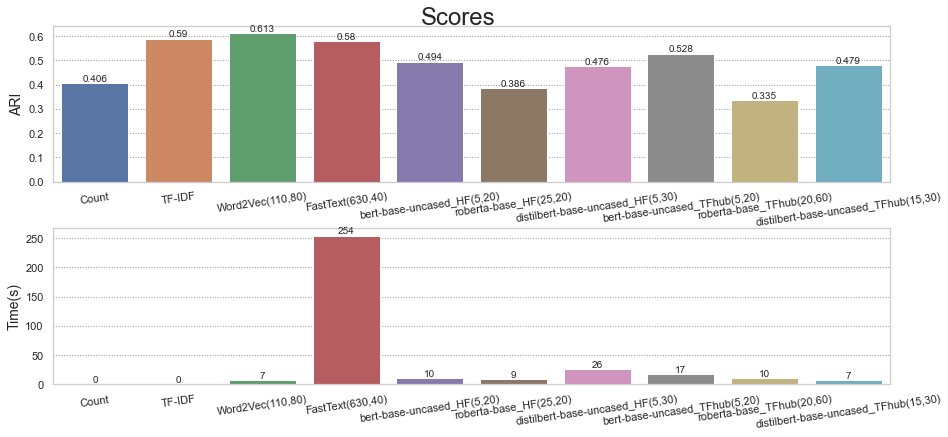

In [61]:
display_scores(Scores)

### USE - Universal Sentence Encoder

In [62]:
sentences = df_corpus['description'].to_list()

In [63]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")


GPU found


In [64]:
def USE_embd(sentences, model_type, batch_size=10, display=True, Scores=None):    
    mode = 'TFhub'
    if len(sentences)>0:        
        if model_type not in my_models:
            save_my_models(model_type, hub.load("https://tfhub.dev/google/universal-sentence-encoder/4"), mode)
            # my_models[mode][model_type]  = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        model = my_models[mode][model_type]  

        time1 = time.time()

        for step in range(len(sentences)//batch_size) :
            idx = step*batch_size
            feat = model(sentences[idx:idx+batch_size])

            if step ==0 :
                features = feat
            else :
                features = np.concatenate((features,feat))

        _time = np.round(time.time() - time1,0)
        save_embeddings(model_type, features)
    
    ARI, X_tsne, labels = ARI_fct(features, categs)

    if display:        
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_type, Scores)
    else:
        return ARI, X_tsne, labels, _time, features    

def USE_grid(sentences, recompute=3):
    model_type = model_name = 'USE'
    best_ARI = best_params.loc[best_params['Model']==model_type, 'ARI'].tolist()[0] if model_type in best_params['Model'].tolist() and recompute==2 else 0
    best_batch_size = best_params.loc[best_params['Model']==model_type, 'size'].tolist()[0] if model_type in best_params['Model'].tolist() and recompute==2 else 0
    best_X_tsne = None
    best_labels = None
    best_time = None

    for batch_size in range(5,5+1, 5):
        print('========================== batch_size =', batch_size, '==========================')
        ARI, X_tsne, labels, _time, features = USE_embd(sentences, batch_size, display=False)     
        print('ARI:', ARI, 'Time:', _time)       

        if ARI > best_ARI:
            best_ARI = ARI
            best_batch_size = batch_size
            best_X_tsne  = X_tsne
            best_labels = labels
            best_time = _time
            save_embeddings(model_type, features)

            # Save Best Params
            if model_type not in best_params['Model'].values:
                i = len(best_params)
                best_params.loc[i, 'Model'] = model_type
            best_params.loc[best_params['Model']==model_type, 'ARI'] = best_ARI
            best_params.loc[best_params['Model']==model_type, 'size'] = best_batch_size
            best_params.loc[best_params['Model']==model_type, 'max_length'] = 0
            best_params.loc[best_params['Model']==model_type, 'time'] = best_time
            save_best_params(model_type)
    # Display Best Params    
    print('best_ARI=', best_ARI, 'best_batch_size=', best_batch_size)
    best_ARI, best_X_tsne, best_labels = ARI_fct(embeddings[model_name], categs)
    TSNE_visu_fct(best_X_tsne, categs, best_labels, best_ARI, best_time, model_type+'('+str(batch_size)+')', Scores)

def USE(recompute=0):
    model_type = 'USE'
    c1= model_type in embeddings
    c2 = model_type in best_params['Model'].values

    batch_size = None
    if c2:
        batch_size = best_params.loc[best_params['Model']==model_type, 'size'].tolist()[0]        
    
    if c1 and recompute==0:
        _time = best_params.loc[best_params['Model']==model_type, 'time'].tolist()[0]
        ARI, X_tsne, labels = ARI_fct(embeddings[model_type], categs)
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_type+'('+str(batch_size)+')', Scores)

    if recompute==1 or (not c1 and c2):
        best_ARI = round(best_params.loc[best_params['Model']==model_type, 'ARI'].tolist()[0], 3)
        ARI = 0
        X_tsne = labels = _time = features = None       

        while ARI < best_ARI:            
            ARI, X_tsne, labels, _time, features = USE_embd(Scores=Scores, sentences=sentences, model_type=model_type, batch_size=batch_size, display=False)
            print('current_ARI:', ARI, 'best_ARI:', best_ARI, 'time:', _time)
        
        clear_output(wait=True)
        save_embeddings(model_type, features)
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_type+'('+str(batch_size)+')', Scores)
        
        best_params.loc[best_params['Model']==model_type, 'ARI'] = ARI
        best_params.loc[best_params['Model']==model_type, 'size'] = batch_size
        best_params.loc[best_params['Model']==model_type, 'time'] = _time
        save_best_params(model_type)
        
    if recompute>=2 or (not c1 and not c2):
        USE_grid(sentences=sentences, recompute=recompute)

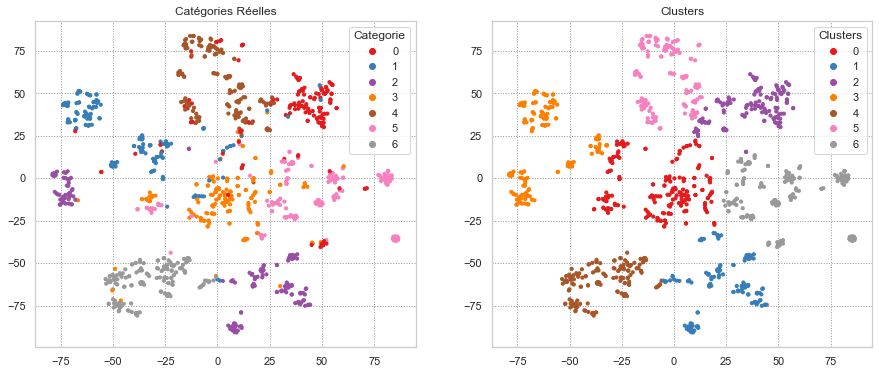

ARI: 0.568 Time: 4


In [65]:
with tf.device('/CPU:0'):
    USE(recompute=0)

### GPT3: OpenAI

In [66]:
sentences = df_corpus['description'].to_list()

In [67]:
def openai_gpt3(model="text-similarity-curie-001", name='GPT3', text=[], recompute=False, concat=False, display=True):
    # Fet the Embeddings with the API
    if (name not in embeddings or recompute) and len(text)>0:
        # Load the private/personal OpenAi API KEY
        with open("openai_key.txt", "r") as f:
            openai.api_key = f.read()
        gpt3 = np.array([get_embedding(txt, engine=model) for txt in text])
        if concat and name in embeddings:
            embeddings[name] = np.concatenate((embeddings[name],gpt3))
        else:
            embeddings[name] = gpt3
        save_embeddings(name, embeddings[name])
    
    if display:
        ARI, X_tsne, labels = ARI_fct(embeddings[name], categs)
        TSNE_visu_fct(X_tsne, categs, labels, ARI, None, name, Scores)

#### Davinci

In [68]:
name='GPT3-davinci'
if name not in embeddings:
    batch = 20
    wait_time = 70    

    for name in range(batch):
        print('Batch :', i+1,'/', batch, '...')
        openai_gpt3(model='text-similarity-davinci-001', name=name, text=sentences[i*len(sentences)//batch:(i+1)*len(sentences)//batch], recompute=True, concat=True, display=i==(batch-1))
        if i<batch-1:
            print("Pause one minute to avoid the 1 minute RateLimit...")
            time.sleep(wait_time)

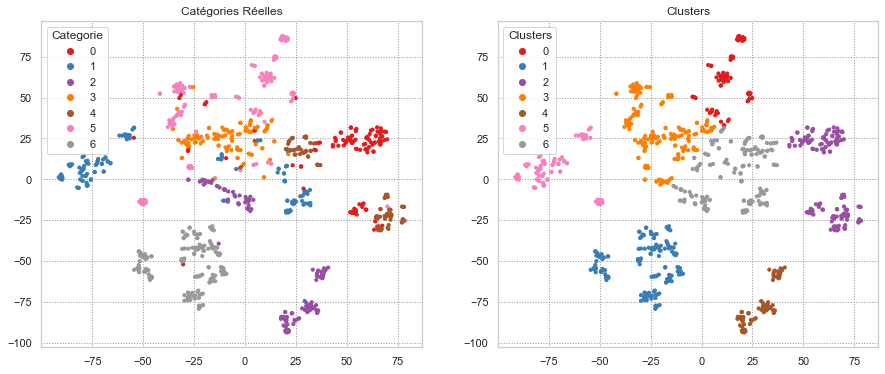

ARI: 0.5099 Time: None


In [69]:
openai_gpt3(name='GPT3-davinci')

#### Curie

In [70]:
name='GPT3-curie'
if name not in embeddings:
    batch = 20
    wait_time = 70

    for i in range(batch):
        print('Batch :', i+1,'/', batch, '...')
        openai_gpt3(model='text-similarity-curie-001', name='GPT3-curie', text=sentences[i*len(sentences)//batch:(i+1)*len(sentences)//batch], recompute=True, concat=True, display=i==(batch-1))
        if i<batch-1:
            print("Pause one minute to avoid the 1 minute RateLimit...")
            time.sleep(wait_time)

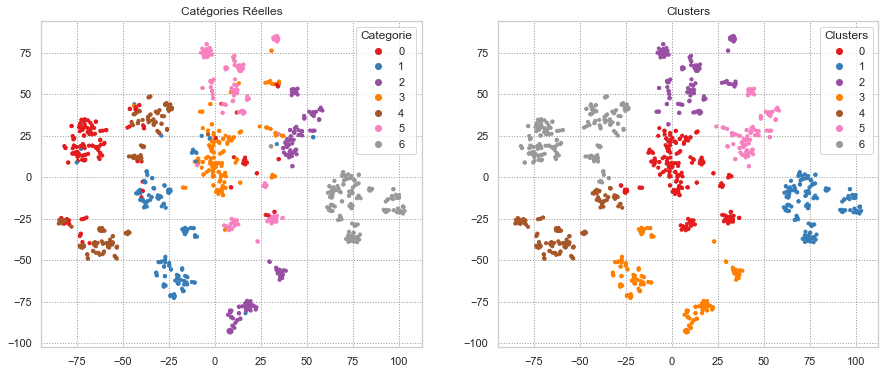

ARI: 0.4909 Time: None


In [71]:
openai_gpt3(name='GPT3-curie')

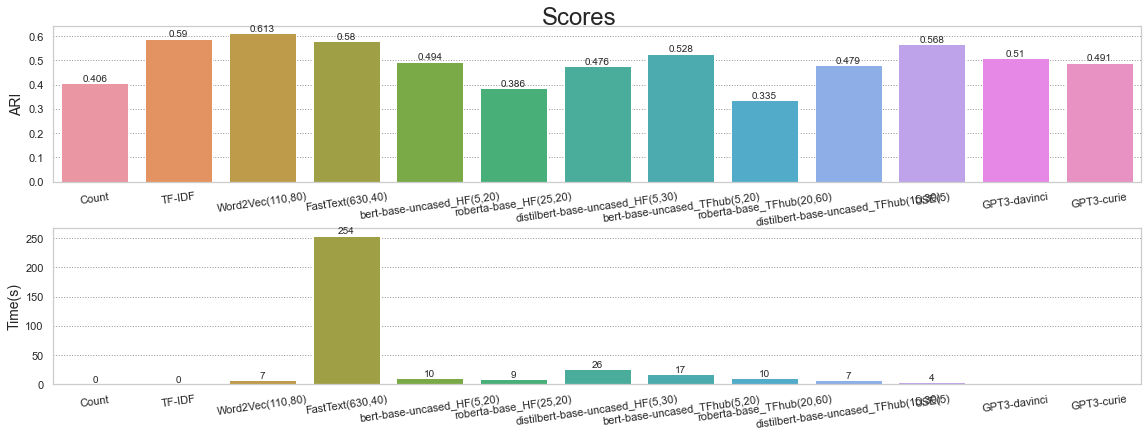

In [72]:
display_scores(Scores)

# Fine Tune : Embeddings Update

In [54]:
num_labels=len(set(categs))

In [55]:
from datasets import Dataset

text_train, text_val, Y_train, Y_val = trainning_sets(df_corpus, 'categ')

text_train['label'] = Y_train
display(text_train)

text_val['label'] = Y_val
display(text_val)

text_train = Dataset.from_pandas(text_train)
text_val = Dataset.from_pandas(text_val)

,name,description,categ_str,label
514,Maxima 04615CMGY Gold Analog Watch - For Men,maximum cmgy gold watch men maximum cmgy gold ...,Watches,6
640,NammaBaby Baby Girl's Animal Print Top & Pyjam...,nammababy baby girl animal print top pyjama pa...,Baby Care,0
469,Ocean CPGW087,key ocean cpgw multipurpose ocean cpgw clear o...,Kitchen & Dining,5
445,Hako 45W Magsafe Laptop Charger For APPLE MacB...,key hako magsafe laptop charger apple macbook ...,Computers,2
918,The Intellect Bazaar Abstract Double Dohar Blu...,intellect bazaar abstract double dohar blue brown,Home Furnishing,4
...,...,...,...,...
478,"Cotonex Yellow, Green Cotton Kitchen Linen Set",cotonex yellow green cotton kitchen linen revi...,Home Furnishing,4
349,Tenda TE-W368R,tenda,Computers,2
590,Babyoye Premium Baby Girl's Grey Leggings,babyoye premium baby girl grey legging legging...,Baby Care,0
751,Rajasthan Crafts Abstract Single Quilts & Comf...,rajasthan craft abstract single quilt comforte...,Home Furnishing,4


,name,description,categ_str,label
464,Fs Mini Klub Baby Girl's Fit and Flare Dress,key mini klub baby girl fit flare dress multi ...,Baby Care,0
773,Ireeya Abstract Single Coral Blanket Blue,ireeya abstract single coral blanket blue,Baby Care,0
138,Rockmantra Night City Ceramic Mug,rockmantra night city ceramic mug give thrilli...,Kitchen & Dining,5
843,Epresent Mfan 1 Fan USB USB Fan,epresent mfan fan usb usb fan epresent mfan fa...,Computers,2
784,EZ Life Funky 3-Pc Kids Cutlery Set-Pleasing P...,offering life funky kid cutlery pleasing panda...,Baby Care,0
...,...,...,...,...
284,Services Junction Beautiful Black and Golden c...,key service junction beautiful black golden di...,Home Decor & Festive Needs,3
300,Elephant 9.84 inch Lid,elephant lid elephant lid best,Kitchen & Dining,5
959,GIMS Brown Viscose Carpet,key gims brown viscose carpet soft polyester v...,Home Furnishing,4
996,L Oreal Eversleek Sulfate - Free Smoothing Sys...,key oreal eversleek sulfate smoothing system i...,Baby Care,0


## Bert

In [56]:
model_name = "bert-base-cased"
batch_size = 5
max_length=20

In [57]:
tokenizer = None
if model_name not in my_tokenizers:
    save_my_tokenizers(model_name, AutoTokenizer.from_pretrained(model_name))
tokenizer = my_tokenizers[model_name]

def tokenize_function(text):
    return tokenizer(text["description"], padding="max_length", truncation=True, max_length=max_length)

In [58]:
small_train_dataset = text_train.map(tokenize_function, batched=False)
small_eval_dataset = text_val.map(tokenize_function, batched=False)

100%|██████████| 210/210 [00:00<00:00, 1505.37ex/s]


In [59]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [60]:
small_train_dataset.to_tf_dataset(batch_size=5)

<PrefetchDataset element_spec={'name': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'description': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'categ_str': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '__index_level_0__': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'input_ids': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)}>

In [61]:
tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    # collate_fn=data_collator,
    batch_size=batch_size,
)
tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    # collate_fn=data_collator,
    batch_size=batch_size,
)

In [62]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

In [63]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

Epoch 1/3
168/168 [==============================] - 62s 212ms/step - loss: 0.9042 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.3479 - val_sparse_categorical_accuracy: 0.9143
Epoch 2/3
168/168 [==============================] - 31s 186ms/step - loss: 0.2915 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.3497 - val_sparse_categorical_accuracy: 0.8857
Epoch 3/3
168/168 [==============================] - 32s 192ms/step - loss: 0.1794 - sparse_categorical_accuracy: 0.9440 - val_loss: 0.3378 - val_sparse_categorical_accuracy: 0.9095


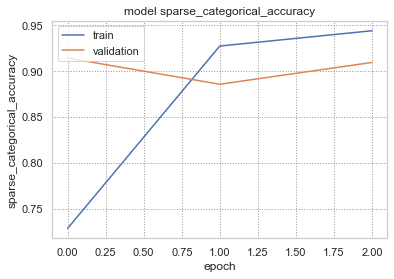

In [64]:
# with tf.device('/CPU:0'):
model_info = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3, workers=cpu_count())

plot_hist(model_info, 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy')    

In [72]:
model.output('bert')

AttributeError: Layer tf_bert_for_sequence_classification has no inbound nodes.

In [65]:
time1 = time.time()
features, last_hidden_states_tot = feature_fct(model, model_name, sentences, max_length, batch_size, mode='TFhub')
_time = np.round(time.time() - time1,0)

ARI, X_tsne, labels = ARI_fct(features, categs)
TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_name+'('+str(batch_size)+','+str(max_length)+')', Scores)    

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[ 0.47226718,  0.03375006, -0.58077717, -0.3376692 ,  4.5489445 ,
        -0.78621817, -2.2190545 ],
       [ 1.2916772 ,  0.0195572 , -0.92830724, -0.08679294,  4.267065  ,
        -1.0219014 , -2.6325738 ],
       [ 2.2997384 , -0.47241667, -1.0154028 , -0.30434713,  3.8552697 ,
        -1.1709503 , -2.3714793 ],
       [ 0.83507305,  0.09614689, -0.68921214, -0.10359322,  4.260642  ,
        -0.9114296 , -2.5518968 ],
       [ 0.7066118 ,  0.06929239, -0.65170205, -0.13888597,  4.304975  ,
        -0.84384054, -2.5097358 ]], dtype=float32)>, hidden_states=None, attentions=None)

KeyError: 'sequence_output'

In [ ]:
model.predict(sentences)

In [ ]:
small_eval_dataset["input_ids"]

In [ ]:
tf_validation_dataset["input_ids"]

TypeError: 'PrefetchDataset' object is not subscriptable

In [ ]:
bert = model.get_layer('bert')
bert

In [ ]:
bert([small_eval_dataset["input_ids"], small_eval_dataset["attention_mask"]])

In [ ]:
bert.output

AttributeError: Layer bert has no inbound nodes.

In [ ]:
bert.summary()

AttributeError: 'TFBertMainLayer' object has no attribute 'summary'

In [ ]:
model([small_eval_dataset["input_ids"], small_eval_dataset["attention_mask"], small_eval_dataset["token_type_ids"]])

In [ ]:
out = model.predict(tf_validation_dataset)

TypeError: predict() got an unexpected keyword argument 'output_hidden_states'

In [ ]:
out

TFSequenceClassifierOutput(loss=None, logits=array([[-2.1692717 , -2.1955917 , -0.5343687 , ..., -1.5394651 ,
        -1.2478122 ,  7.926229  ],
       [ 7.3846    , -1.2690612 , -1.6157625 , ..., -0.7732738 ,
        -1.5406712 , -2.1141133 ],
       [-1.0195446 ,  6.6416774 , -0.5425714 , ..., -0.66523385,
        -0.7555675 , -1.4854748 ],
       ...,
       [-1.7420444 , -0.9977969 , -1.5206634 , ..., -1.5489802 ,
        -1.3042083 , -0.9253826 ],
       [ 3.1422431 , -0.06900918, -2.4985871 , ..., -1.943461  ,
        -1.346492  , -1.7152326 ],
       [-0.29796654, -0.80491006,  5.797723  , ..., -1.9739538 ,
        -1.8761835 , -0.9517501 ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_130 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
Total params: 108,315,655
Trainable params: 108,315,655
Non-trainable params: 0
_________________________________________________________________


In [66]:
encoder = TFBertModel.from_pretrained(model_name)

    
# This is the input for the tokens themselves(words from the dataset after encoding):
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')

token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')

# attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
# Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH, 
# and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
attention_mask = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='attention_mask')

# Use previous inputs as BERT inputs:
output = encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]

# We can also add dropout as regularization technique:
#output = tf.keras.layers.Dropout(rate=0.15)(output)

# Provide number of classes to the final layer:
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output)

# Final model:
model2 = tf.keras.models.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [ ]:
model_info2 = model2.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3, workers=cpu_count())

plot_hist(model_info2, 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy') 

In [68]:
encoder.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3 = Sequentizl

In [ ]:
0/0

ZeroDivisionError: division by zero

## USE

In [ ]:
from tensorflow.python.saved_model import tag_constants

scope = 'finetune'

with tf.Session(graph=graph) as sess:
    
    # universal sentence encoder input/output
    in_tensor = tf.get_default_graph().get_tensor_by_name(scope + '/module/fed_input_values:0')
    ou_tensor = tf.get_default_graph().get_tensor_by_name(scope + '/module/Encoder_en/hidden_layers/l2_normalize:0')

    # a simple softmax classification on top of universal sentence encoder
    input_y = tf.placeholder(tf.int32, shape=(None))
    labels = tf.one_hot(input_y, 4)
    logits = tf.layers.dense(ou_tensor, 4)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    sess.run(tf.global_variables_initializer())
    sess.run(tf.get_default_graph().get_operation_by_name('finetune/init_all_tables'))

    for epoch in range(10):
        feed_dict = {
            in_tensor: X,
            input_y: y
        }
        sess.run(optimizer, feed_dict)

    message_embeddings_ = sess.run(ou_tensor, feed_dict={in_tensor: X})

## OpenAI:  GPT3

In [ ]:
df_gpt = df_corpus[['description', 'categ_str']]
df_gpt = df_gpt.rename(columns={'description': 'prompt', 'categ_str':'completion'})
display(df_gpt)
df_gpt.to_json("Flipkart.jsonl", orient='records', lines=True)

,prompt,completion
0,key elegance polyester multicolor abstract eye...,Home Furnishing
1,sathiyas cotton bath towel bath towel red yell...,Baby Care
2,key eurospa cotton terry face towel size small...,Baby Care
3,key santosh royal fashion cotton printed king ...,Home Furnishing
4,key jaipur print cotton floral king sized doub...,Home Furnishing
...,...,...
1045,oren empower extra large self adhesive sticker...,Baby Care
1046,wallmantra large vinyl sticker sticker bring h...,Baby Care
1047,uberlyfe extra large pigmented polyvinyl film ...,Baby Care
1048,wallmantra medium vinyl sticker sticker wallma...,Baby Care


In [ ]:
with open("openai_key.txt", "r") as f:
    openai.api_key = f.read()
os.environ['OPENAI_API_KEY'] = openai.api_key

In [ ]:
!openai tools fine_tunes.prepare_data -f Flipkart.jsonl -q

Logging requires wandb to be installed. Run `pip install wandb`.

C:\Python39\lib\site-packages\openai\validators.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["prompt"] += suffix
C:\Python39\lib\site-packages\openai\validators.py:414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["completion"] = x["completion"].apply(



Analyzing...

- Your file contains 1050 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 57 duplicated prompt-completion sets. These are rows: [55, 61, 152, 155, 156, 163, 168, 176, 177, 180, 182, 185, 251, 272, 285, 303, 322, 335, 349, 351, 355, 364, 369, 385, 419, 429, 433, 434, 435, 496, 508, 511, 516, 531, 536, 543, 548, 553, 554, 556, 559, 567, 572, 574, 575, 578, 579, 583, 588, 603, 710, 762, 763, 786, 787, 788, 1048]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/prep

In [ ]:
!openai api fine_tunes.create -t "Flipkart_prepared_train.jsonl" -v "Flipkart_prepared_valid.jsonl" -m curie --compute_classification_metrics --classification_n_classes 7

Logging requires wandb to be installed. Run `pip install wandb`.
Uploaded file from Flipkart_prepared_train.jsonl: file-oUfVCa5lNc7mTiukvNizqsbk
Uploaded file from Flipkart_prepared_valid.jsonl: file-VNZYPEji5FSNwvWoFUZVaI2M
Created fine-tune: ft-SVraRC9TrGmCCWhnU0j8FD8p
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-07-07 17:06:53] Created fine-tune: ft-SVraRC9TrGmCCWhnU0j8FD8p
[2022-07-07 17:07:01] Fine-tune costs $0.50
[2022-07-07 17:07:01] Fine-tune enqueued. Queue number: 0
[2022-07-07 17:07:04] Fine-tune started
[2022-07-07 17:07:05] If `compute_classification_metrics` is `True`, each of the classes must start with a different token. You can view your class tokenizations at https://beta.openai.com/tokenizer?view=bpe.. Fine-tune failed. For help, please contact OpenAI and include your fine-tune ID: ft-SVraRC9TrGmCCWhnU0j8FD8p

Job failed. Please contact support@openai.com if you need assistance.



Upload progress:   0%|          | 0.00/247k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 247k/247k [00:00<00:00, 165Mit/s]

Upload progress:   0%|          | 0.00/61.2k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 61.2k/61.2k [00:00<00:00, 61.3Mit/s]


# Classification

## OvA LightGBM

### Default Embeddings

==========================> Word2Vec <==========================


c:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


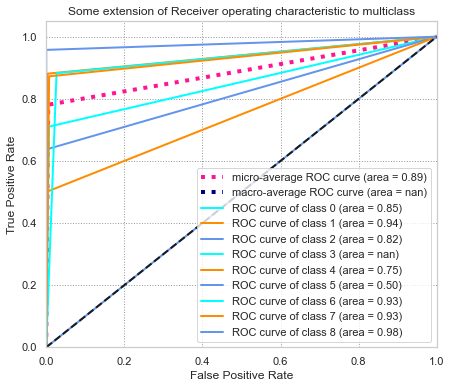

AUC 0.8878968253968254 Time 95.0
==========================> bert-base-uncased <==========================


c:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


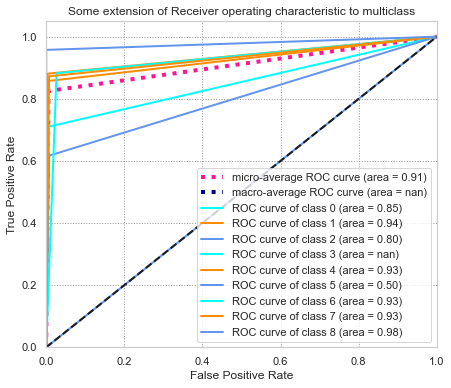

AUC 0.9097222222222222 Time 81.0
==========================> roberta-base <==========================


c:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


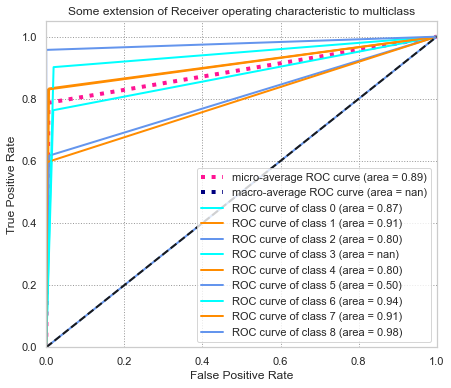

AUC 0.8906746031746031 Time 84.0
==========================> distilbert-base-uncased <==========================


c:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


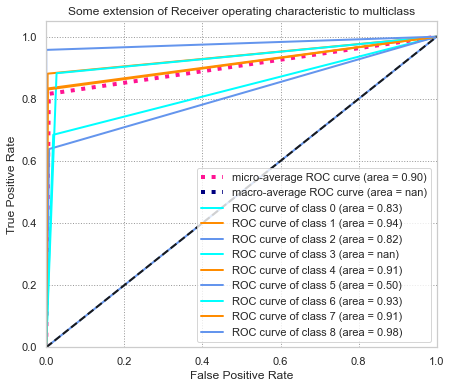

AUC 0.9045634920634922 Time 67.0


In [ ]:
Perfs = pd.DataFrame(columns=['Model', 'AUC', 'hue'], index=[])

for model_name, embds in embeddings.items():
    print ('==========================>', model_name, '<==========================')
    y = 'y'
    data = pd.DataFrame(embeddings['Word2Vec'])    
    data[y] = pd.Series(categs)

    time1 = time.time()
    AUC = OvA_ROC(data, LGBMClassifier(), y)
    time2 = np.round(time.time() - time1,0)    

     # Sauvgarder les scores
    stop = False
    try:
        if Scores == None:
            stop = True
    except:
        pass
    if not stop:
        # Evaluatation
        i = len(Perfs)
        Perfs.loc[i, 'Model'] = model_name
        Perfs.loc[i, 'AUC'] = AUC
        Perfs.loc[i, 'Time(s)'] = time2
        # Convertion de type
        Perfs['AUC'] = Perfs['AUC'].astype('float')    
        print('AUC', AUC, 'Time', time2)

In [ ]:
Perfs

,Model,AUC,hue,Time(s)
0,Word2Vec,0.887897,NaN,95.0
1,bert-base-uncased,0.909722,NaN,81.0
2,roberta-base,0.890675,NaN,84.0
3,distilbert-base-uncased,0.904563,NaN,67.0


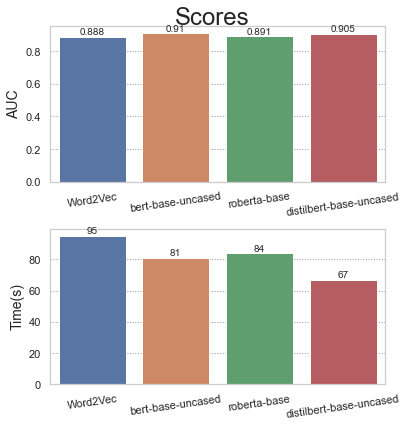

In [ ]:
display_scores(Perfs)

### Updated Embeddings (Transfer Learning)

## Zero SHot Classification

In [ ]:
sequence_to_classify = sentences[0]
sequence_to_classify

'key elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height curtain enhances look interior curtain made high polyester fabric eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight elegance polyester multicolor abstract eyelet door curtain height elegance designed door eyelet model name abstract polyester door curtain model duster multicolor dimension length content curtain body polyester'

In [ ]:
categs_str

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [ ]:
API_TOKEN = None
with open("HF_API_TOKEN.txt", "r") as f:
    API_TOKENy = f.read()

In [ ]:
inference = InferenceApi(repo_id="bert-base-uncased", task="zero-shot-classification", token=API_TOKEN)

inputs = sentences[0]
params = {"candidate_labels":categs_str}
inference(inputs, params)

{'sequence': 'key elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height curtain enhances look interior curtain made high polyester fabric eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight elegance polyester multicolor abstract eyelet door curtain height elegance designed door eyelet model name abstract polyester door curtain model duster multicolor dimension length content curtain body polyester',
 'labels': ['Computers',
  'Baby Care',
  'Watches',
  'Kitchen & Dining',
 